# Import Data

Import Fiat 500e diagnostic data from CSV exported from the shared Google Drive document (https://docs.google.com/spreadsheets/d/16aLIw9OhJ2d-Z88i-QqWEPdHW27jEYvMP5wDWQPqr0o/edit#gid=231199137).

In [1]:
import csv
import numpy as np
from sklearn.linear_model import LinearRegression

data_path = 'data/500e.csv'

with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader))

print(headers)
print(data.shape)
print(data[len(data)-2:len(data)])

['Timestamp', 'Notes', 'Year', 'Age', 'Mileage', 'Full_AmpH_Capacity', 'SOH', 'SOH-R', 'SOH-C', '0.0_19.9', '20.0_to_29.9', '30.0_to_39.9', '40.0_49.9', '50.0_59.9', '60.0_69.9', '70.0_79.9', '80.0_100.0', '<-220', '-220_-210', '-210_-120', '-210_-20', '-20_-5', '-5_-0.5', '-0.5_3', '3_50', '50_80', '80_160', '160_180', '> 180', 'T < -30C', '-30< T <-20', '-20< T <-10', '-10< T <0', '0< T <10', '10< T <20', '20< T < 30', '30< T <40', '40< T <50', '50< T <60', '60< T']
(88, 40)
[['4/26/2020 13:52:06' '' '2015' '5' '42328' '53.7' '100' '99.61' '82.35'
  '890' '3955' '13965' '27980' '45070' '66495' '106520' '309470' '5' '0'
  '470' '37975' '18850' '44290' '327675' '125315' '2160' '450' '0' '0'
  '0' '0' '0' '0' '1115' '199040' '253600' '120595' '0' '0' '0']
 ['5/2/2020 22:00:52' '2nd Owner. San Diego-based.' '2016' '4' '16666'
  '58.1' '100' '99.61' '89.02' '2680' '6865' '12350' '23780' '31015'
  '38775' '55255' '126415' '130' '55' '725' '12415' '8095' '26220'
  '223835' '24780' '655' '22

# Clean Data

Clean up the data.


In [58]:
AGES = data[:,3].astype(int)
MILEAGES = data[:,4].astype('int')
FULL_AMPH_CAP = data[:,5].astype('float')
SOHs = data[:,6:8]
SOC = data[:,9:17].astype('int')
SOP = data[:,18:29].astype('int')
TEMPS = data[:,30:40].astype('int')


#Remove outliers (FULL_AMPH_CAP < 40)

j = 1
index = []
for i in range(1, len(FULL_AMPH_CAP)):
    if FULL_AMPH_CAP[i] < 40:
        index = np.append(index, i)
        j = j + 1
    elif MILEAGES[i] < 100:
        index = np.append(index, i)
        j = j + 1
    elif SOC[i, 1] == 0 or SOP[i, 1] == 0:
        index = np.append(index, i)
        j = j + 1
        
        
AGES = np.delete(AGES, index, 0)
MILEAGES = np.delete(MILEAGES, index, 0)
FULL_AMPH_CAP = np.delete(FULL_AMPH_CAP , index, 0)
SOHs = np.delete(SOHs, index, 0)
SOC = np.delete(SOC, index, 0)
SOP = np.delete(SOP, index, 0)
TEMPS = np.delete(TEMPS, index, 0)

#Convert to percentages

for i in range (1, len(SOC)):
    SOC_CUM = sum(SOC[i,:])    
    SOP_CUM = sum(SOP[i,:])
    TEMPS_CUM = sum(TEMPS[i,:])    
    SOC[i,:] = SOC[i,:].astype(float)*100/SOC_CUM
    SOP[i,:] = SOP[i,:].astype(float)*100/SOP_CUM
    TEMPS[i,:] = TEMPS[i,:].astype(float)*100/TEMPS_CUM    
    

    

/home/ian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/ian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/ian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/ian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/ian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/ian/.local/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: using a non-integer array as obj in delete will r

# Visualise Data

Create some histograms to visualise the data.

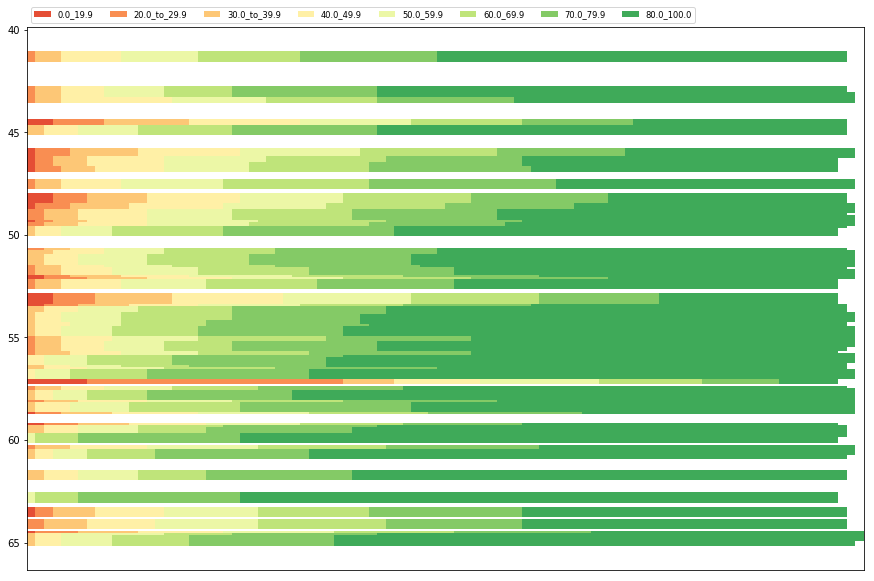

In [59]:
import matplotlib.pyplot as plt

def plot_barchart_dist(input_data, category_names, labels):
    
    data_cum = input_data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, input_data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(input_data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = input_data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
      
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

n = len(SOC)
plot_barchart_dist(SOC[1:n], headers[9:17], FULL_AMPH_CAP[1:n])
ax.set_title('Time in SOC vs. AmpH Capacity')
plt.show()

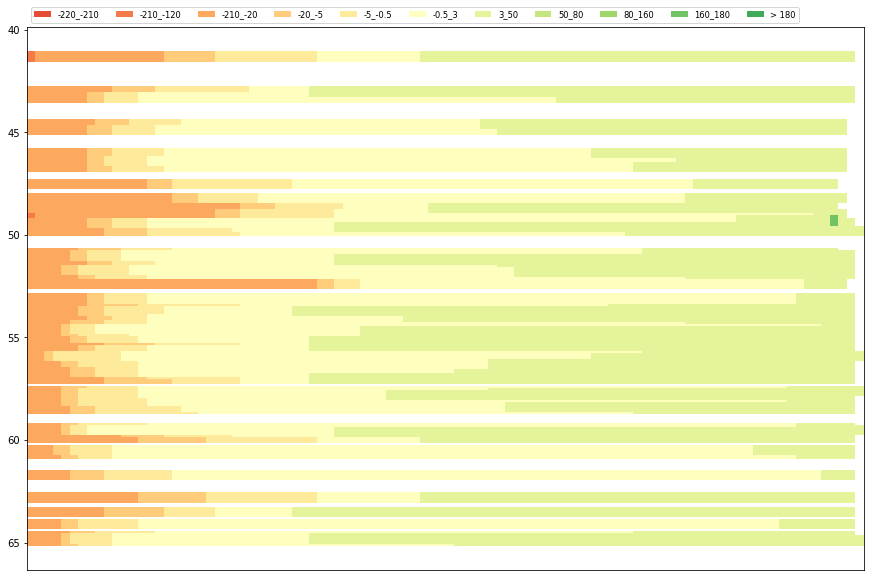

In [60]:
plot_barchart_dist(SOP[1:n], headers[18:29], FULL_AMPH_CAP[1:n])
ax.set_title('Power Usage vs. AmpH Capacity')
plt.show()

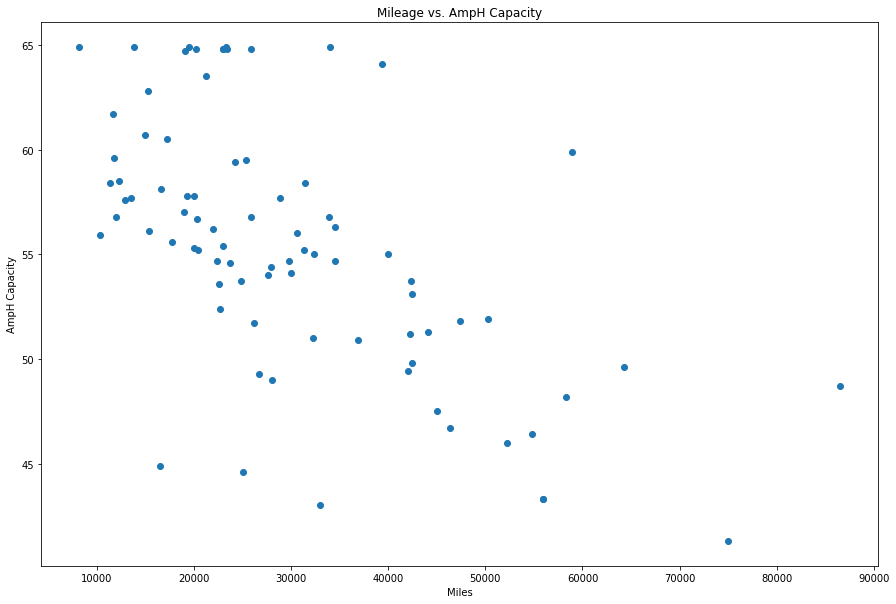

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(MILEAGES[1:n], FULL_AMPH_CAP[1:n])
ax.set_title('Mileage vs. AmpH Capacity')
ax.set_ylabel('AmpH Capacity')
ax.set_xlabel('Miles')
plt.show()

# Create Linear Regression Model

1. Firstly, partition data into a training set and test set.
2. Perform linear regression on each subset of data as features:
       2a. SOC
       2b. SOC + MILEAGE
       2c. SOP
       2d. SOP + MILEAGE
       2e. SOC + SOP
       2f. SOC + SOP + MILEAGE
       2g. TEMPS

In [146]:
import math

def lr(x, y, p):
    train_set_size = np.round(0.9*len(x)).astype(int)
    print(train_set_size)

    train_x = x[1:train_set_size]
    train_y = y[1:train_set_size]

    test_x = x[train_set_size+1:len(x)]
    test_y = y[train_set_size+1:len(y)]

    model = LinearRegression(n_jobs = -1)
    model.fit(train_x,train_y)

    r_sq = model.score(train_x, train_y)
   

    y_pred = model.intercept_ + np.sum(model.coef_ * test_x, axis=1)
    error = 0    
    distance = math.sqrt( sum( pow(a-b, 2) for a, b in zip(test_y, y_pred) ) )  
    
    print('coefficient of determination:', r_sq)
    if p == 'true':      
        print('intercept:', model.intercept_)
        print('slope:', model.coef_)
        for i in range(1, len(test_x)):
            print('Actual AmpH Value: ', test_y[i])
            print('Predicted AmpH Value: ',y_pred[i])
    print('Error (euclidean distance): ', distance)    
    
    return distance, model
    
def scale_features(x):

    x_dim = np.shape(x)  
    scaled_x = np.array(x)
    for i in range(1, x_dim[1]):
        x_min = np.min(x[i,:])
        print(x_min)
        x_max = np.max(x[i,:])
        print(x_max)
        #scaled_x[i,:] = (a-x_max/(x_max-x_min)) for a in x[i,:]      
    
    return scaled_x

In [151]:
from sklearn import preprocessing 

distances = []

In [152]:
#2a SOC
  
x = SOC.astype(float)
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)
print(x[1:3])
d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[ 0.  1.  3.  5.  8. 10. 17. 52.]
 [ 0.  0.  1.  3.  6. 10. 17. 59.]]
76
('coefficient of determination:', 0.23108672578241518)
('Error (euclidean distance): ', 18.504321360555085)


In [129]:
#2b SOC + MILEAGE

x = []

x = np.insert(SOC.astype(float), 0, MILEAGES.astype(float), axis=1)

print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[1.2877e+04 0.0000e+00 1.0000e+00 3.0000e+00 5.0000e+00 8.0000e+00
  1.0000e+01 1.7000e+01 5.2000e+01]
 [2.2413e+04 0.0000e+00 0.0000e+00 1.0000e+00 3.0000e+00 6.0000e+00
  1.0000e+01 1.7000e+01 5.9000e+01]]
76
('coefficient of determination:', 0.37617662825393705)
('Error (euclidean distance): ', 10.751501235993485)


In [130]:
#2c SOP

x = SOP.astype(float)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[ 0.  0.  4.  3.  6. 76.  9.  0.  0.  0.  0.]
 [ 0.  0.  4.  2.  6. 82.  3.  0.  0.  0.  0.]]
76
('coefficient of determination:', 0.2786049942679619)
('Error (euclidean distance): ', 28.133355465619342)


In [131]:
#2b SOP + MILEAGE

x = []
x = np.insert(SOP.astype(float), 0, MILEAGES.astype(float), axis=1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[1.2877e+04 0.0000e+00 0.0000e+00 4.0000e+00 3.0000e+00 6.0000e+00
  7.6000e+01 9.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.2413e+04 0.0000e+00 0.0000e+00 4.0000e+00 2.0000e+00 6.0000e+00
  8.2000e+01 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
76
('coefficient of determination:', 0.3990618262295444)
('Error (euclidean distance): ', 16.479400003210294)


In [132]:
#2e. SOC + SOP

x = []
x = np.append(SOC, SOP, axis=1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[ 0  1  3  5  8 10 17 52  0  0  4  3  6 76  9  0  0  0  0]
 [ 0  0  1  3  6 10 17 59  0  0  4  2  6 82  3  0  0  0  0]]
76
('coefficient of determination:', 0.43232815787843315)
('Error (euclidean distance): ', 24.057087726573595)


In [133]:
#2f. SOC + SOP + MILEAGE

x = []
x = np.append(SOC, SOP, axis=1)
x = np.insert(x, 0, MILEAGES, axis=1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[12877     0     1     3     5     8    10    17    52     0     0     4
      3     6    76     9     0     0     0     0]
 [22413     0     0     1     3     6    10    17    59     0     0     4
      2     6    82     3     0     0     0     0]]
76
('coefficient of determination:', 0.4887606124798235)
('Error (euclidean distance): ', 17.06348907758901)


In [134]:
#MILEAGE

x = MILEAGES.reshape(-1,1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[12877]
 [22413]]
76
('coefficient of determination:', 0.28978514931074817)
('Error (euclidean distance): ', 8.444832247702893)


In [135]:
#TEMPS

x = TEMPS
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[ 0  0  0 20 46 26  6  0  0  0]
 [ 0  0  0  7 28 48 15  0  0  0]]
76
('coefficient of determination:', 0.025159023432423044)
('Error (euclidean distance): ', 19.786422250585154)


In [136]:
# SOC + SOP + MILEAGE + TEMPS

x = []
x = np.append(SOC, SOP, axis=1)
x = np.append(x, TEMPS, axis=1)
x = np.insert(x, 0, MILEAGES, axis=1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[12877     0     1     3     5     8    10    17    52     0     0     4
      3     6    76     9     0     0     0     0     0     0     0    20
     46    26     6     0     0     0]
 [22413     0     0     1     3     6    10    17    59     0     0     4
      2     6    82     3     0     0     0     0     0     0     0     7
     28    48    15     0     0     0]]
76
('coefficient of determination:', 0.29807213270947897)
('Error (euclidean distance): ', 8.622463342576562)


In [137]:
# SOC + SOP + MILEAGE + TEMPS + AGE

x = []
x = np.append(SOC, SOP, axis=1)
x = np.append(x, TEMPS, axis=1)
x = np.insert(x, 0, MILEAGES, axis=1)
x = np.insert(x, 0, AGES, axis=1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

[[    4 12877     0     1     3     5     8    10    17    52     0     0
      4     3     6    76     9     0     0     0     0     0     0     0
     20    46    26     6     0     0     0]
 [    4 22413     0     0     1     3     6    10    17    59     0     0
      4     2     6    82     3     0     0     0     0     0     0     0
      7    28    48    15     0     0     0]]
76
('coefficient of determination:', 0.29802385781844987)
('Error (euclidean distance): ', 8.591798972347748)


In [181]:
#MILEAGE

x = MILEAGES.reshape(-1,1)
x = np.insert(x, 0, AGES, axis=1)
print(x[1:3])
y = FULL_AMPH_CAP #Full AmpH Capacity (most important value)

d = lr(x, y, 'false')
distances = np.append(distances, d[0])

y_pred = np.zeros((10, 100000))
for a in range(1,10):
    for m in range(1000, 50000):
        y_pred[a,m] = d[1].intercept_ + np.sum(d[1].coef_ * np.array([a,m]).reshape(1, -1), axis=1)

print(y_pred[4, 17000])
print(y_pred[5, 50000])
print(y_pred[8, 90000])

[[    4 12877]
 [    4 22413]]
76
('coefficient of determination:', 0.3022854389254106)
('Error (euclidean distance): ', 6.909374331722774)
58.18740927752704
0.0
0.0


In [189]:
print(y_pred[2, 10000])
print(y_pred[3, 10000])
print(y_pred[4, 10000])
print(y_pred[4, 20000])
print(y_pred[4, 30000])
print(y_pred[5, 40000])

61.00255073060651
60.29732041785641
59.59209010510632
57.58540320856449
55.578716312022664
52.86679910273074
